### Prediction model

Devo creare un modello di previsione di prezzo di assicurazione basandomi su tre parametri principali: eta, bmi, fumo, e se pratica sport o no. 
La prima cosa è che visto che non ho dati passati, devo creare una funzione che descrive la verà relazione tra questi parametri e il prezzo dell'assicurazione. Questa funzione la puoi creare tu, dev essere non lineare, e ci deve essere un minimo di random icità per simulare la variabilità reale dei dati. 
Una volta che questa funzione è creata, devo generar eun dataset con 1000 campioni, dove per ogni campione genero casualmente i valori di eta, bmi, fumo e sport, e calcolo il prezzo dell'assicurazione usando la funzione che hai creato. Dammi il codice python per fare questo.

In [1]:
import numpy as np
import pandas as pd

# Impostiamo un seed per rendere i risultati riproducibili
np.random.seed(42)

# Funzione che simula il prezzo assicurativo
def prezzo_assicurazione(eta, bmi, fumo, sport):
    """
    Calcola il prezzo dell'assicurazione in base a:
    - eta: età in anni (18–80)
    - bmi: indice di massa corporea (15–40)
    - fumo: 0 = non fumatore, 1 = fumatore
    - sport: 0 = non praticante, 1 = praticante
    
    La funzione è non lineare e include rumore casuale.
    """
    # Base cost: cresce con età e BMI in modo non lineare
    base = 200 + 3.5 * (eta ** 1.1) + 15 * np.log(bmi + 1)
    
    # Impatto del fumo (moltiplicativo)
    fattore_fumo = np.where(fumo == 1, 1.8 + 0.3 * np.random.rand(len(fumo)), 1.0)
    
    # Sconto per chi fa sport (riduzione non lineare)
    fattore_sport = np.where(sport == 1, 0.8 - 0.1 * np.random.rand(len(sport)), 1.0)
    
    # Rumore casuale per simulare variabilità reale
    rumore = np.random.normal(0, 100, size=len(eta))
    
    prezzo = base * fattore_fumo * fattore_sport + rumore
    
    # Assicuriamoci che il prezzo non sia negativo
    prezzo = np.maximum(prezzo, 100)
    
    return prezzo

# Generiamo 1000 campioni casuali
n = 1000
eta = np.random.randint(18, 80, n)
bmi = np.random.uniform(15, 40, n)
fumo = np.random.choice([0, 1], size=n, p=[0.7, 0.3])  # 30% fumatori
sport = np.random.choice([0, 1], size=n, p=[0.5, 0.5])  # 50% sportivi

# Calcoliamo il prezzo
prezzo = prezzo_assicurazione(eta, bmi, fumo, sport)

# Creiamo un DataFrame
df = pd.DataFrame({
    "eta": eta,
    "bmi": bmi,
    "fumo": fumo,
    "sport": sport,
    "prezzo": prezzo
})

# Mostriamo le prime righe
print(df.head())

# Se vuoi salvarlo su file:
# df.to_csv("dataset_assicurazione.csv", index=False)


   eta        bmi  fumo  sport      prezzo
0   56  24.418474     0      1  406.495147
1   69  33.739457     0      1  433.243003
2   46  24.824736     0      1  281.362091
3   32  35.729106     0      1  405.036135
4   60  29.227037     0      1  357.128304


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# 1️⃣ Se hai già il dataset
# =========================
# (Se hai usato il codice precedente, df è già definito.
# Altrimenti puoi caricarlo da file:)
# df = pd.read_csv("dataset_assicurazione.csv")

# =========================
# 2️⃣ Definiamo variabili input e target
# =========================
X = df[["eta", "bmi", "fumo", "sport"]]
y = df["prezzo"]

# =========================
# 3️⃣ Suddivisione train/test
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 4️⃣ Creazione e training del modello
# =========================
rf = RandomForestRegressor(
    n_estimators=200,       # numero di alberi
    max_depth=None,         # profondità massima (None = libera)
    random_state=42,
    n_jobs=-1               # usa tutti i core
)

rf.fit(X_train, y_train)

# =========================
# 5️⃣ Valutazione del modello
# =========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# =========================
# 6️⃣ (Opzionale) Importanza delle feature
# =========================
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\nImportanza delle variabili:")
print(importances.sort_values(ascending=False))


Mean Absolute Error: 85.12
Root Mean Squared Error: 111.39
R² Score: 0.840

Importanza delle variabili:
fumo     0.520174
eta      0.269721
sport    0.112706
bmi      0.097399
dtype: float64


In [4]:
!pip install seaborn

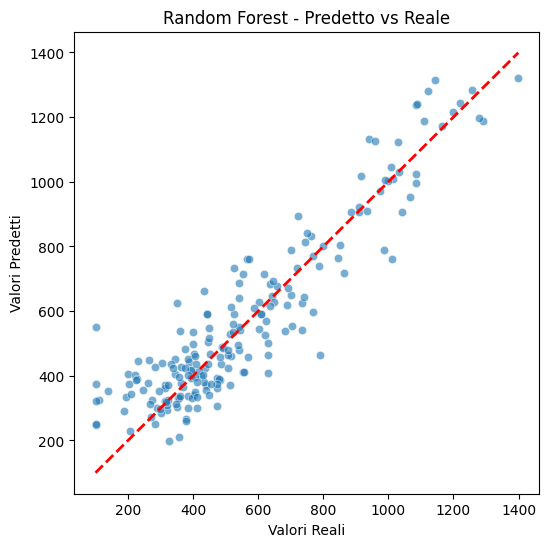

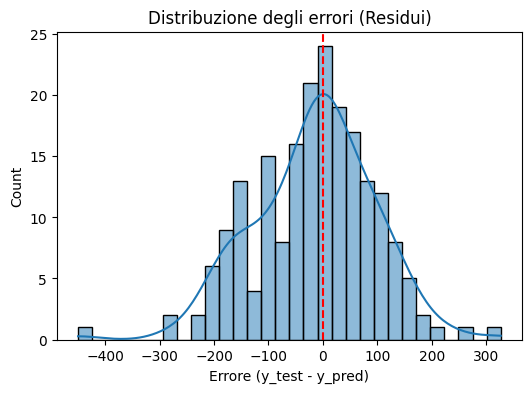

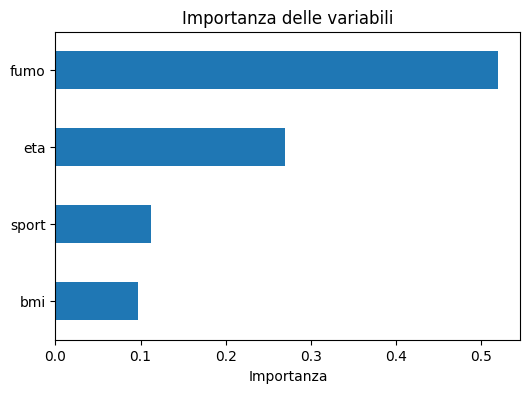

MAE = 85.12
RMSE = 111.39
R² = 0.840


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Valori predetti ===
y_pred = rf.predict(X_test)

# === 1️⃣ Predetto vs Reale ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valori Reali")
plt.ylabel("Valori Predetti")
plt.title("Random Forest - Predetto vs Reale")
plt.show()

# === 2️⃣ Distribuzione residui ===
residui = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residui, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuzione degli errori (Residui)")
plt.xlabel("Errore (y_test - y_pred)")
plt.show()

# === 3️⃣ Importanza delle variabili ===
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Importanza delle variabili")
plt.xlabel("Importanza")
plt.show()

# === 4️⃣ Metriche di performance ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")


se la mia predizione è sotto, va bene perche si fa margine, se è sopra, devo calcolare quanto devo alzare il prezzo basandomi sui miei dati (predico con il modello, e calcolo real_price vs predicted_price, e in base a questo calcolo un fattore di aggiustamento del prezzo. => predicted_price - real_price)/real_price

Prezzo base medio: 551.79 €
count    200.000000
mean       2.856817
std       48.737380
min      -64.147467
25%      -31.990470
50%      -15.601049
75%       24.924319
max      139.627852
Name: adjustment_percent, dtype: float64


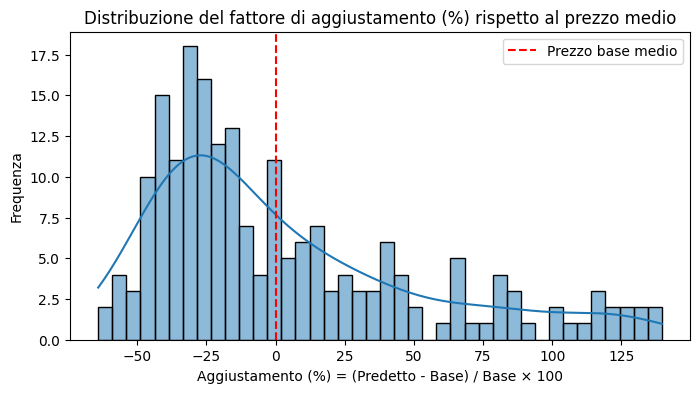

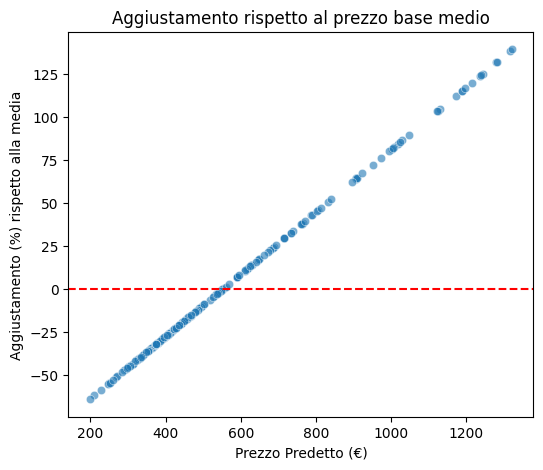

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === Prezzo medio base (baseline) ===
base_price = y_test.mean()
print(f"Prezzo base medio: {base_price:.2f} €")

# === Calcolo del fattore di aggiustamento percentuale ===
predicted_price = y_pred
adjustment = ((predicted_price - base_price) / base_price) * 100

# === Creiamo un DataFrame per analisi ===
adjustment_df = pd.DataFrame({
    "predicted_price": predicted_price,
    "adjustment_percent": adjustment
})

# === Statistiche generali ===
print(adjustment_df["adjustment_percent"].describe())

# === Visualizziamo la distribuzione ===
plt.figure(figsize=(8,4))
sns.histplot(adjustment, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--', label='Prezzo base medio')
plt.title("Distribuzione del fattore di aggiustamento (%) rispetto al prezzo medio")
plt.xlabel("Aggiustamento (%) = (Predetto - Base) / Base × 100")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

# === (Facoltativo) scatter per vedere come variano gli aggiustamenti ===
plt.figure(figsize=(6,5))
sns.scatterplot(x=predicted_price, y=adjustment, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prezzo Predetto (€)")
plt.ylabel("Aggiustamento (%) rispetto alla media")
plt.title("Aggiustamento rispetto al prezzo base medio")
plt.show()
